In [19]:
import matplotlib.pyplot as pt
import pandas as pd
import numpy as np
from sklearn import metrics
from sklearn.preprocessing import MinMaxScaler
from math import sqrt
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (18, 6)
mpl.rcParams['axes.grid'] = False

In [2]:
#dataset preparation with lag
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = pd.DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = pd.concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg

In [3]:
#locally weighted regression
def lwr(inp, out, k):
    m,n = np.shape(inp)
    ypred = np.zeros(m)    
    for i in range(m):
        ypred[i] = inp[i] * beta(inp[i], inp, out, k)
    #print("The final prediction is :",ypred)
    return ypred

def lwr1(x0, inp, out, k):
    m,n = np.shape(inp)
    ypred = np.zeros(m)    
    ypred = x0 * beta(x0, inp, out, k)
    #print("The final prediction is :",ypred)
    return ypred

def beta(point, inp, out, k):
    wt = kernal(point, inp, k)
    #print("The weight of betas is",wt)
    beta_val = (inp.T * (wt*inp)).I * inp.T * wt * out
    #print("The weight is beta value is",beta_val)
    return beta_val

def kernal(point, inp, k):
    l,b = np.shape(inp)
    weights = np.mat(np.eye((l)))
    #print(weights)    
    for i in range(l):
        #print(point.shape,inp[i].shape)
        diff = point - inp[i]
        weights[i,i] = np.exp(np.dot(diff,diff.T) / (-2.0 * (k**2)))
    return weights

In [6]:
#df = pd.read_csv('kodaguAllYearRainDam.csv')
df = pd.read_csv('allYearHarangi.csv')
df
a = "RCDATE"
b = "Dates"
df['month'] = pd.DatetimeIndex(df[b]).month
df['year'] = pd.DatetimeIndex(df[b]).year
mask = (df['month'] <= 12)
mask1 = (df['year'] == 2011)
df = df.loc[mask]
df = df.loc[mask1]
df.set_index(b,inplace = True)
df.drop(['month','year',"Present Storage(TMC)",'Reservoir Level(TMC)','Outflow'],axis = 1,inplace = True)
#df.drop(['Inflow'],axis = 1,inplace = True)
df

,Inflow,MADIKERI,SOMWARPET,VIRAJPET
Dates,,,,
2011-01-01,142.000000,0.000000,0.000000,0.000000
2011-01-02,239.000000,0.000000,0.000000,0.000000
2011-01-03,166.000000,0.000000,0.000000,0.000000
2011-01-04,118.000000,0.000000,0.000000,0.000000
2011-01-05,130.000000,0.000000,0.000000,0.000000
...,...,...,...,...
2011-12-27,77.000000,1.493925,2.274299,0.366822
2011-12-28,68.000000,1.485047,2.259813,0.364486
2011-12-29,69.000000,1.476168,2.245327,0.362150


In [7]:
lag_val = 5

In [8]:
values = df.values
values = values.astype('float32')
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
# frame as supervised learning
reframed = series_to_supervised(values, lag_val, 1)#lag of 4 days
# drop columns we don't want to predict
reframed.drop(reframed.columns[[-1,-2,-3]], axis=1, inplace=True)
reframed.head()
print(lag_val)

5


In [9]:
values = reframed.values
train_x = values[:,:-1]
Inflow = values[:,-1]
Inflow = Inflow.reshape((train_x.shape[0],1))

Inflow.shape
train_x.shape

(360, 20)

In [10]:
#df1 = pd.read_csv('kodaguAllYearRainDam.csv')
df1 = pd.read_csv('allYearHarangi.csv')
df1['month'] = pd.DatetimeIndex(df1[b]).month
df1['year'] = pd.DatetimeIndex(df1[b]).year
df1
mask = (df1['month'] <= 12)
mask1 = (df1['year'] > 2011)#&(df1['year'] <= 2018))
df1 = df1.loc[mask]
df1 = df1.loc[mask1]
df1.set_index(b,inplace = True)
df1.drop(['month','year',"Present Storage(TMC)",'Reservoir Level(TMC)','Outflow'],axis = 1,inplace = True)
#df1.drop(['Inflow'],axis = 1,inplace = True)
df1

,Inflow,MADIKERI,SOMWARPET,VIRAJPET
Dates,,,,
2012-01-01,140.311688,1.449533,2.201869,0.355140
2012-01-02,139.467532,1.440654,2.187383,0.352804
2012-01-03,138.623377,1.431776,2.172897,0.350467
2012-01-04,137.779221,1.422897,2.158411,0.348131
2012-01-05,136.935065,1.414019,2.143925,0.345794
...,...,...,...,...
2018-12-27,103.000000,0.000000,0.000000,0.000000
2018-12-28,98.000000,0.000000,0.000000,0.000000
2018-12-29,102.000000,0.000000,0.000000,0.000000


In [11]:
values1 = df1.values
values1 = values1.astype('float32')
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
# frame as supervised learning
reframed1 = series_to_supervised(values1, lag_val, 1)#lag of 4 days
# drop columns we don't want to predict
reframed1.drop(reframed.columns[[-1,-2,-3]], axis=1, inplace=True)
reframed1
print(lag_val)

5


In [12]:
values1 = reframed1.values
Actuall_inflow = values1[:,-1]
test_x = values1[:,:-1]

print(train_x.shape,Inflow.shape)
print(test_x.shape)
Actuall_inflow.shape

(360, 20) (360, 1)
(2552, 20)


(2552,)

In [15]:
ypred = []
train_X = train_x
train_y = Inflow
for i in test_x:
    ypred.append(lwr1(i, train_X, train_y, 10000))
ypred = np.array(ypred).reshape(Actuall_inflow.shape[0],1)

In [16]:
ypred

array([[140.56386848],
       [139.69921221],
       [138.83462326],
       ...,
       [ 89.43397648],
       [ 95.27687662],
       [ 91.44060146]])

In [17]:
print("MSE = ",metrics.mean_squared_error(Actuall_inflow,ypred))
print("RMSE = ",sqrt(metrics.mean_squared_error(Actuall_inflow,ypred)))

MSE =  14241325.949014539
RMSE =  3773.768136626115


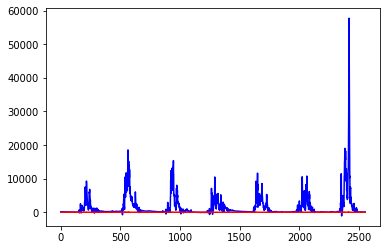

In [26]:
pt.plot(ypred,c='blue')
pt.plot(Actuall_inflow,c='red')

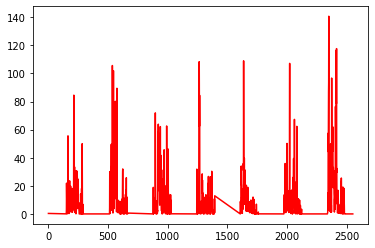

In [27]:
pt.plot(Actuall_inflow,c='red')

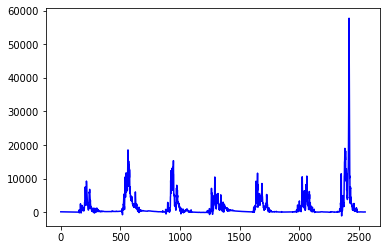

In [22]:
pt.plot(ypred,c='blue')